# Process example for FEEM data

<span style="color:blue">USE THIS AS A TEMPLATE TO MAKE YOUR OWN DATA PROCESSING FILES:</span>. <span style="color:red">SAVE EACH SAMPLE AS A NEW FILENAME</span>.

The **first block** below is housekeeping.  It makes the paths with the data searchable. As well as the scripts for data processing (these should not need to be changed).  

The data you are processing needs to be put in the DATA or the PRIVATE directory.  The DATA directory will be backed up to github.  PRIVATE will only be stored locally so could be lost ... but you can always back up yourself.  The reason I did it this way is in case you want to avoid making your raw data public on github.  Without context I don't think the data could be publishable by anyone else but I any user to have the option to keep their data private.

The **second block** you need to edit with your data file name (data file stored in DATA or PRIVATE directory).  There are instructions in DATA for how to format the data, but should be easy using Aqualog exported data.  ALSO here enter the DOC if you know it (enter 1 if you do not).  The FEEM surface plot will be normalized to DOC (so if you don't want it normalized enter 1 here as well).

Also in this block you can enter a caxisvalue (default is [] or empty).  The caxis value will limit the height of the colourmap so you can compare between samples (otherwise it just defaults to maximize the range).  Also c-axis can help you "zoom in" if the scatter light it too much.

The **third block** is for plotting the FEEM.  The minimum and maximum excitation wavelengths can be specified as well as the width of the scattering lines. If you want to see the scattering lines comment out this line

[F,em,ex]=FINTERPFILL(data,scatterfactor,exmin,exmax,stepsize,flagg);

If we need publishable images I suggest using matlab.  But for routine data analysis this tool should be sufficient.
 
**fourth block** just exports the optical indices.

**fifth block** use the ID number from OPENfluor database to select what set of PARAFAC components will be modelled to your data.  As of writing this models 17305 and older have been uploaded here.  You can find the model ID looking at the database

[OPENFluor database](https://openfluor.lablicate.com/)  <span style="color:red">login needed</span>

[Summary is posted here (with thumbnail images of each component)](https://docs.google.com/spreadsheets/d/1-Psv4vUMNjIBb6seB5hVN828BOHneAJuYYlWnzZ11J8/edit?usp=sharing)

Also the OPENFluordatabase directory here has an ipynb file for each of the entries in the database.  This is also where new entries will be added as they come available.

After running this cell, all the components are shown and thier "concentrations" to explain the observed data.  The % variability of the original FEEM explained is also shown.

Finally **block six** shows the data, the model and the residuals of the FEEM being processed.

# 1. HOUSEKEEPING

In [176]:
% housekeeping
% add scriptpath and OPENFluordatabase
txt=pwd;
n=length(txt); rootpath=txt;
rootpath=txt(1:n-12)
scriptpath=[rootpath,'/FEEMscripts'];
addpath(scriptpath);
OPENFluorpath=[rootpath,'/OPENFluordatabase'];
addpath(OPENFluorpath);
% add  datapath privatedata paths
rootpath=txt; rootpath=txt;
datapath=[rootpath,'/DATA'];
addpath(datapath);
privatepath=[rootpath,'/PRIVATE']; c=exist(privatepath); % only add path if it exists
if c>0; addpath(privatepath); end
% clear data and number format
clear; format short e
% turn off warnings
warning off
graphics_toolkit ("notebook"); 
%graphics_toolkit ("plotly"); 

rootpath = /home/jovyan/


# 2. ENTER DATA !!! EDIT THIS !!!!

In [177]:
%input the FEEM data file and DOC conc

% you have to change this to match the data in either the DATA directory
% or the PRIVATE directory.  NOT in both places.

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%5
dataname=['LM8_1']; DOC=1;
caxisvalue=[]; % put in a caxisvalue if you want a fixed colour axis (to compare between samples, otherwise it automatically rescales)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%555

txt=['[FEEM,ABS]=',dataname,';']; eval(txt)
data=FEEM; Abs=ABS(:,2); lambda=ABS(:,1); Abs=Abs-min(Abs); % correct for baseline negative values.
%Abs(Abs<0)=0; % negative values don't make sense.

# 3. This makes the FEEM surface.

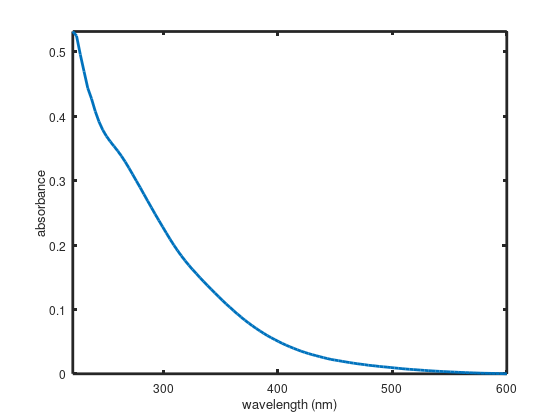

In [178]:
% process the data
%scatterfactor=0.01; exmin=200; exmax=400; flagg=0; 
%[F,em,ex]=Fprocess(data,scatterfactor,exmin,exmax,flagg);
scatterfactor=0.085; exmin=240; exmax=400; 
stepsize=4; %stepsize is the nm gap on ex and em resampling, if 0 use the original
flagg=0; % no diagnostic plot.  if flag=1 then plot to make sure scatter "zeros" are all gone
[F,em,ex]=FINTERPFILL(data,scatterfactor,exmin,exmax,stepsize,flagg);
% plot aborbance

plot(lambda,Abs,'linewidth',2); 
xlabel('wavelength (nm)'); ylabel('absorbance')
set(gca,'linewidth',2,'fontsize',12)
axis([ min(lambda) max(lambda) 0 max(Abs)])

%interplate so abs matches ex and em
Aem=interp1(lambda,Abs,em); % original data
Aex=interp1(lambda,Abs,ex,'pchip','extrap');

%correct the data

for i=1:size(F,1)
    for j=1:size(F,2)
        factor(i,j)=1*0.5*(Aex(i)+Aem(j));
        Fcorr(i,j)=F(i,j)*(10^(factor(i,j)));
    end
end


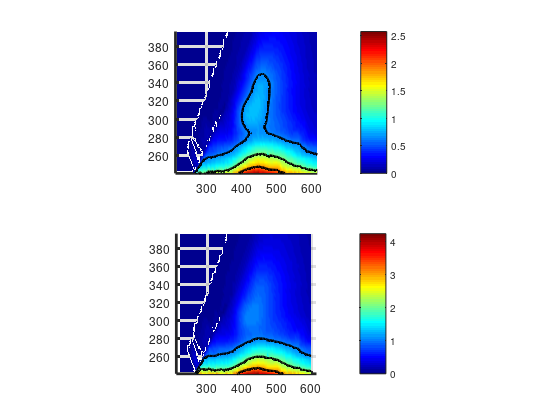

In [179]:
%F=Fcorr; % use absorbance corrected data

%interpolate to fill scattered light to make prettier plots
%scatterfactor=0.085; %exmin=240; exmax=400; 
%stepsize=4; %stepsize is the nm gap on ex and em resampling, if 0 use the original
%flagg=0; % no diagnostic plot.  if flag=1 then plot to make sure scatter "zeros" are all gone
%[F,em,ex]=FINTERPFILL(data,scatterfactor,exmin,exmax,stepsize,flagg);

if isempty(caxisvalue)==1; caxisvalue=max(max(F./DOC)); caxisvaluecorr=max(max(Fcorr./DOC));end
subplot(211); makecontourplot(F./DOC,em,ex,1); caxis([0 caxisvalue]); axis square;  colorbar
subplot(212); makecontourplot(Fcorr./DOC,em,ex,1); caxis([0 caxisvaluecorr]); axis square;   colorbar

# 4. OPTICAL INDICES FROM FEEM

In [180]:
% report optical indices

BIX=calcBIX(F,em,ex)
gap=1; HI1=calcHI(F,em,ex,gap)
FI=calcFI(F,em,ex)

BIXcorr=calcBIX(Fcorr,em,ex)
gap=1; HI1corr=calcHI(Fcorr,em,ex,gap)
FIcorr=calcFI(Fcorr,em,ex)


BIX = 4.1653e-01


HI1 = 2.0524e+00


FI = 1.0478e+00


BIXcorr = 4.3710e-01


HI1corr = 1.7262e+00


FIcorr = 1.0621e+00


# 5. PARAFAC-lite call.  

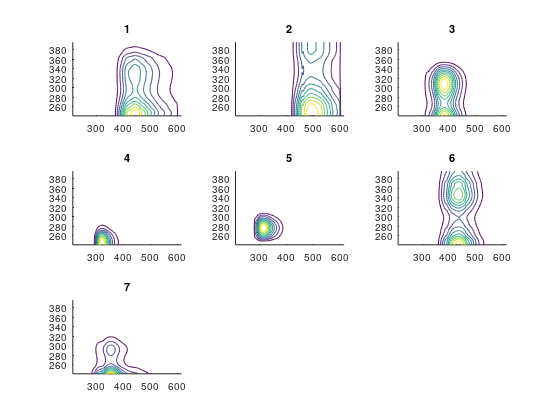

p,1,2,3,4,5,6,7
1,36.3574,24.6385,3.79485e-55,3.21636e-47,7.99642e-14,1.20335e-22,24.5079


display = percent data explained 98.2128 %


In [181]:
% plot the components, original, fit and residuals

IDno=['2882'];

[Ffit,percentdataexplained]=parafaclite(F,em,ex,IDno);

percent=num2str(percentdataexplained);

display=['percent data explained ',percent,' %']


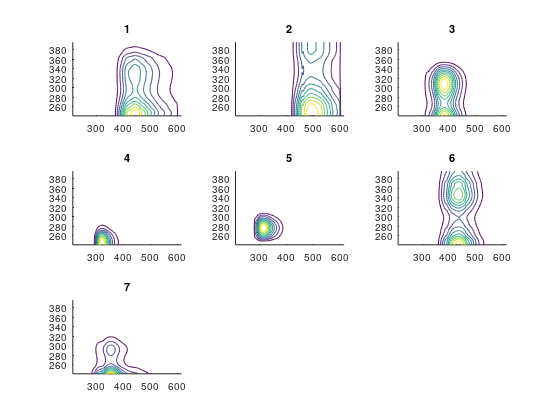

p,1,2,3,4,5,6,7
1,54.6852,33.6532,6.84352e-47,13.7015,1.78478e-13,1.37363e-20,35.2627


display = percent data explained 105.1229 %


In [182]:
% plot the components, original, fit and residuals

IDno=['2882'];

[Ffit,percentdataexplained]=parafaclite(Fcorr,em,ex,IDno);

percent=num2str(percentdataexplained);

display=['percent data explained ',percent,' %']


# 6. The PARAFAC-lite model and the residuals

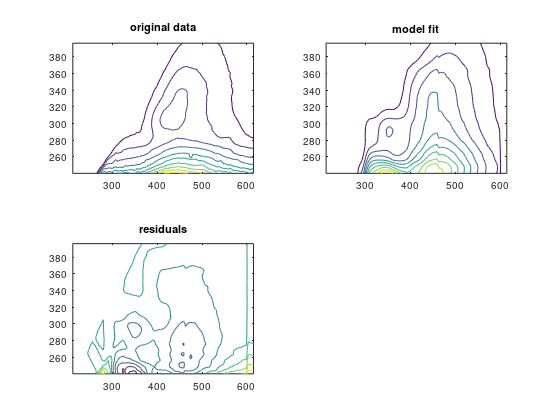

In [183]:
subplot(221)
contour(em,ex,F); title('original data')
subplot(222)
contour(em,ex,Ffit); title('model fit')
subplot(223)
contour(em,ex,F-Ffit); title('residuals')

In [184]:
% for export to matlab by cut and paste the corrected FEEM

Display=[...
-99 ex
em' Fcorr'
]
save Display.txt Display -ascii

Display,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
1,-99,240.3,244.3,248.3,252.3,256.3,260.3,264.3,268.3,272.3,276.3,280.3,284.3,288.3,292.3,296.3,300.3,304.3,308.3,312.3,316.3,320.3,324.3,328.3,332.3,336.3,340.3,344.3,348.3,352.3,356.3,360.3,364.3,368.3,372.3,376.3,380.3,384.3,388.3,392.3,396.3
2,210.901,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,214.901,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,218.901,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,222.901,0,0,0,0,-0,-0,0,0,-0,-0,-0,0,-0,-0,-0,-0,-0,-0,-0,-0,0,-0,0,-0,-0,0,0,0,-0,0,-0,-0,-0,-0,-0,-0,0,-0,-0,0
6,226.901,0,0,-0,-0,0,-0,0,-0,-0,-0,-0,-0,-0,-0,-0,0,-0,0,-0,0,-0,-0,-0,-0,0,-0,0,-0,0,-0,0,0,0,-0,0,0,-0,-0,0,0
7,230.901,0,0,-0,0,-0,0,0,-0,0,0,-0,-0,-0,-0,-0,0,-0,0,0,-0,-0,-0,0,-0,0,-0,-0,0,-0,0,0,-0,-0,-0,-0,0,0,-0,-0,-0
8,234.901,0,0,0,0,-0,-0,0,0,0,-0,0,0,-0,0,-0,-0,0,0,-0,0,0,0,0,0,0,-0,0,0,-0,-0,-0,0,0,0,0,0,0,0,0,0
9,238.901,0,-0,0,0,-0,0,0,-0,0,0,-0,0,-0,0,0,-0,-0,0,0,-0,-0,-0,-0,-0,-0,-0,0,-0,0,0,-0,0,-0,0,-0,0,0,0,-0,-0
10,242.901,0,-0,0,-0,0,-0,0,-0,0,-0,0,-0,-0,-0,-0,0,-0,-0,0,0,-0,0,0,0,-0,0,-0,-0,-0,0,-0,0,-0,0,0,-0,-0,-0,0,-0
